In [139]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import openTSNE
from umap import UMAP
from sklearn.ensemble import HistGradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

warnings.filterwarnings("ignore")

# 数据预处理

导入数据

In [140]:
train = pd.read_csv("/root/autodl-tmp/XJTU-ELEC427304-homework/kaggle_graduate_prediect/train.csv", index_col="id")
test = pd.read_csv("/root/autodl-tmp/XJTU-ELEC427304-homework/kaggle_graduate_prediect/test.csv", index_col="id")

In [141]:
target = "Target"

分离特征

In [142]:
features = test.columns.to_list()

In [143]:
categorical_features = train.select_dtypes(include=int).columns.to_list()
continuous_features = train.select_dtypes(include=float).columns.to_list()

In [144]:
continuous_features

['Previous qualification (grade)',
 'Admission grade',
 'Curricular units 1st sem (grade)',
 'Curricular units 2nd sem (grade)',
 'Unemployment rate',
 'Inflation rate',
 'GDP']

In [145]:
discrete_features = [col for col in categorical_features if col.startswith("Curricular")] + ["Age at enrollment"]
discrete_features

['Curricular units 1st sem (credited)',
 'Curricular units 1st sem (enrolled)',
 'Curricular units 1st sem (evaluations)',
 'Curricular units 1st sem (approved)',
 'Curricular units 1st sem (without evaluations)',
 'Curricular units 2nd sem (credited)',
 'Curricular units 2nd sem (enrolled)',
 'Curricular units 2nd sem (evaluations)',
 'Curricular units 2nd sem (approved)',
 'Curricular units 2nd sem (without evaluations)',
 'Age at enrollment']

In [146]:
categorical_features = list(np.setdiff1d(categorical_features, discrete_features))
categorical_features

['Application mode',
 'Application order',
 'Course',
 'Daytime/evening attendance',
 'Debtor',
 'Displaced',
 'Educational special needs',
 "Father's occupation",
 "Father's qualification",
 'Gender',
 'International',
 'Marital status',
 "Mother's occupation",
 "Mother's qualification",
 'Nacionality',
 'Previous qualification',
 'Scholarship holder',
 'Tuition fees up to date']

In [147]:
train.shape

(76518, 37)

In [148]:
test.shape

(51012, 36)

数据类型、计数、唯一值数量、缺失值数量以及一些其他的统计信息

In [149]:
def customDescription(df: pd.DataFrame, numeric_only: bool = True):
    # 如果参数 numeric_only 为真，则选择 DataFrame 中的数值列
    if numeric_only:
        df = df.select_dtypes(include=np.number)

    # 创建一个新的 DataFrame，用于存储描述性统计信息
    desc = pd.DataFrame(index=df.columns.to_list())
    
    # 存储每列的数据类型
    desc['type'] = df.dtypes
    
    # 存储每列的非空值数量
    desc['count'] = df.count()
    
    # 存储每列的唯一值数量
    desc['nunique'] = df.nunique()
    
    # 计算每列的唯一值占比
    desc['%unique'] = desc['nunique'] / len(df) * 100
    
    # 存储每列的空值数量
    desc['null'] = df.isnull().sum()
    
    # 计算每列的空值占比
    desc['%null'] = desc['null'] / len(df) * 100
    
    # 使用 DataFrame 的 describe 方法计算描述性统计信息，并将结果与之前的统计信息合并
    desc = pd.concat([desc, df.describe().T.drop('count', axis=1)], axis=1)

    # 如果参数 numeric_only 为真，计算并添加每列的偏度和峰度
    if numeric_only:
        desc["skew"] = df.skew()
        desc["kurtosis"] = df.kurtosis()

    # 将所有统计信息四舍五入到两位小数
    desc = desc.round(2)
    
    return desc


In [150]:
train_description = customDescription(train)
train_description.to_csv('train_description.csv')

In [151]:
test_description = customDescription(test)
test_description.to_csv('test_description.csv')

重复行的数量

In [152]:
train.duplicated().sum()

0

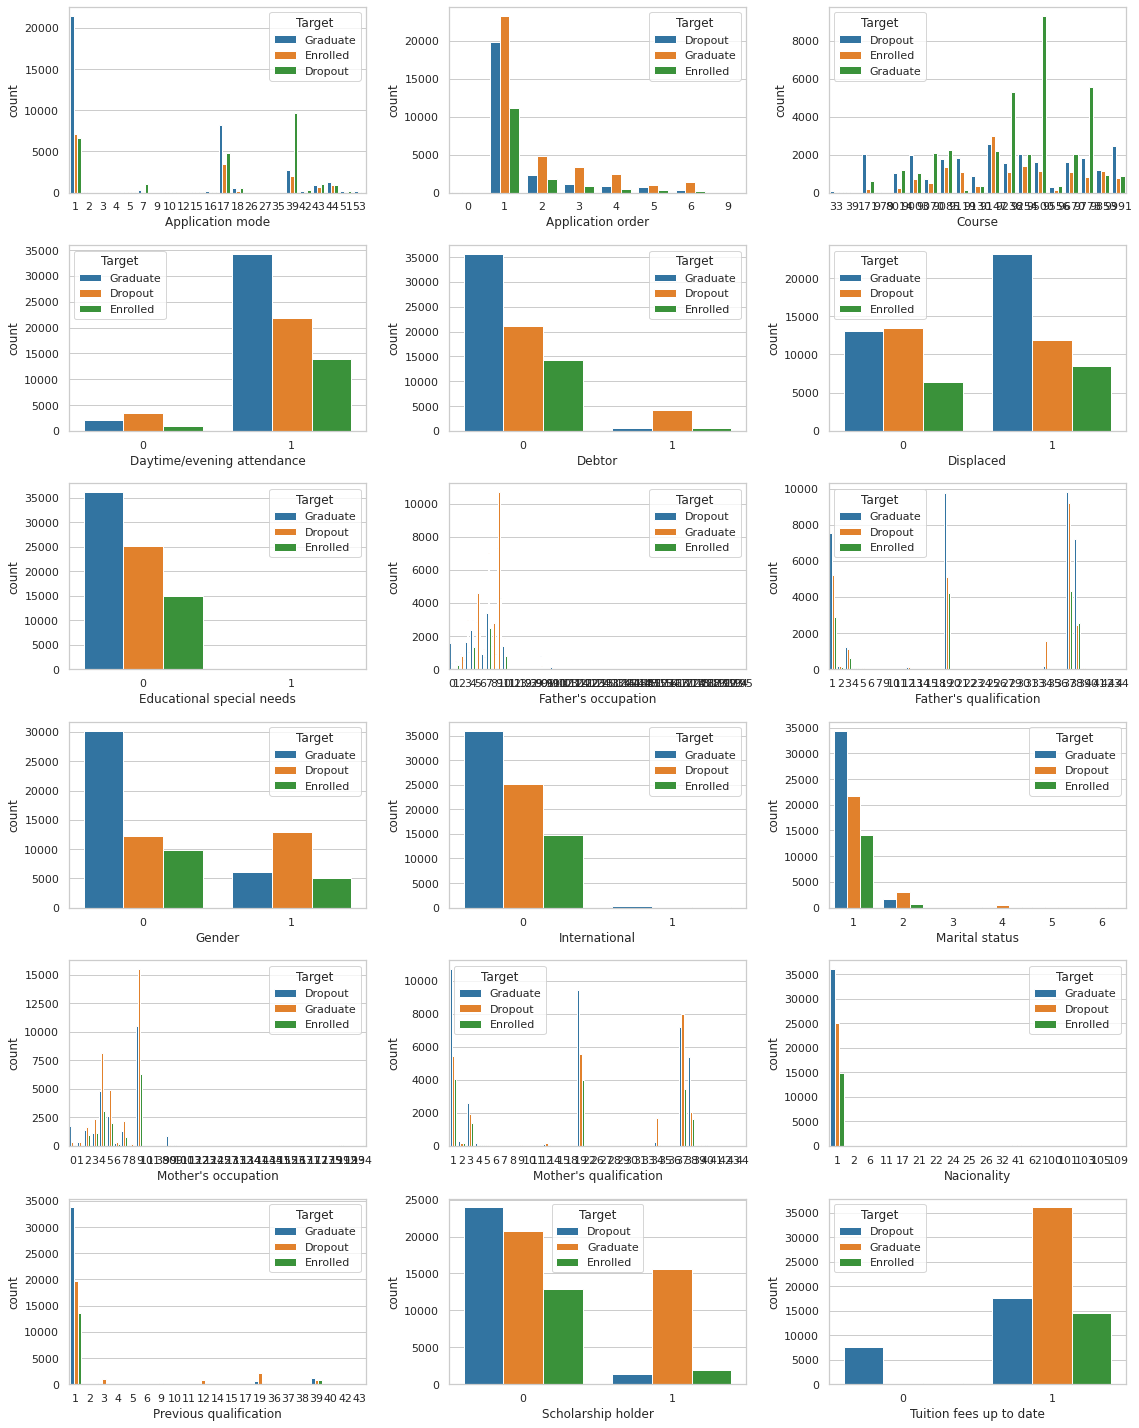

In [153]:
custom_palette = ['#1f77b4', '#ff7f0e', '#2ca02c']

# 使用自定义调色板
plt.figure(figsize=(16, 20))
for i, col in enumerate(categorical_features):
    plt.subplot(6, 3, i+1)
    sns.countplot(data=train, x=col, hue=target, palette=custom_palette)
plt.tight_layout()
plt.show()

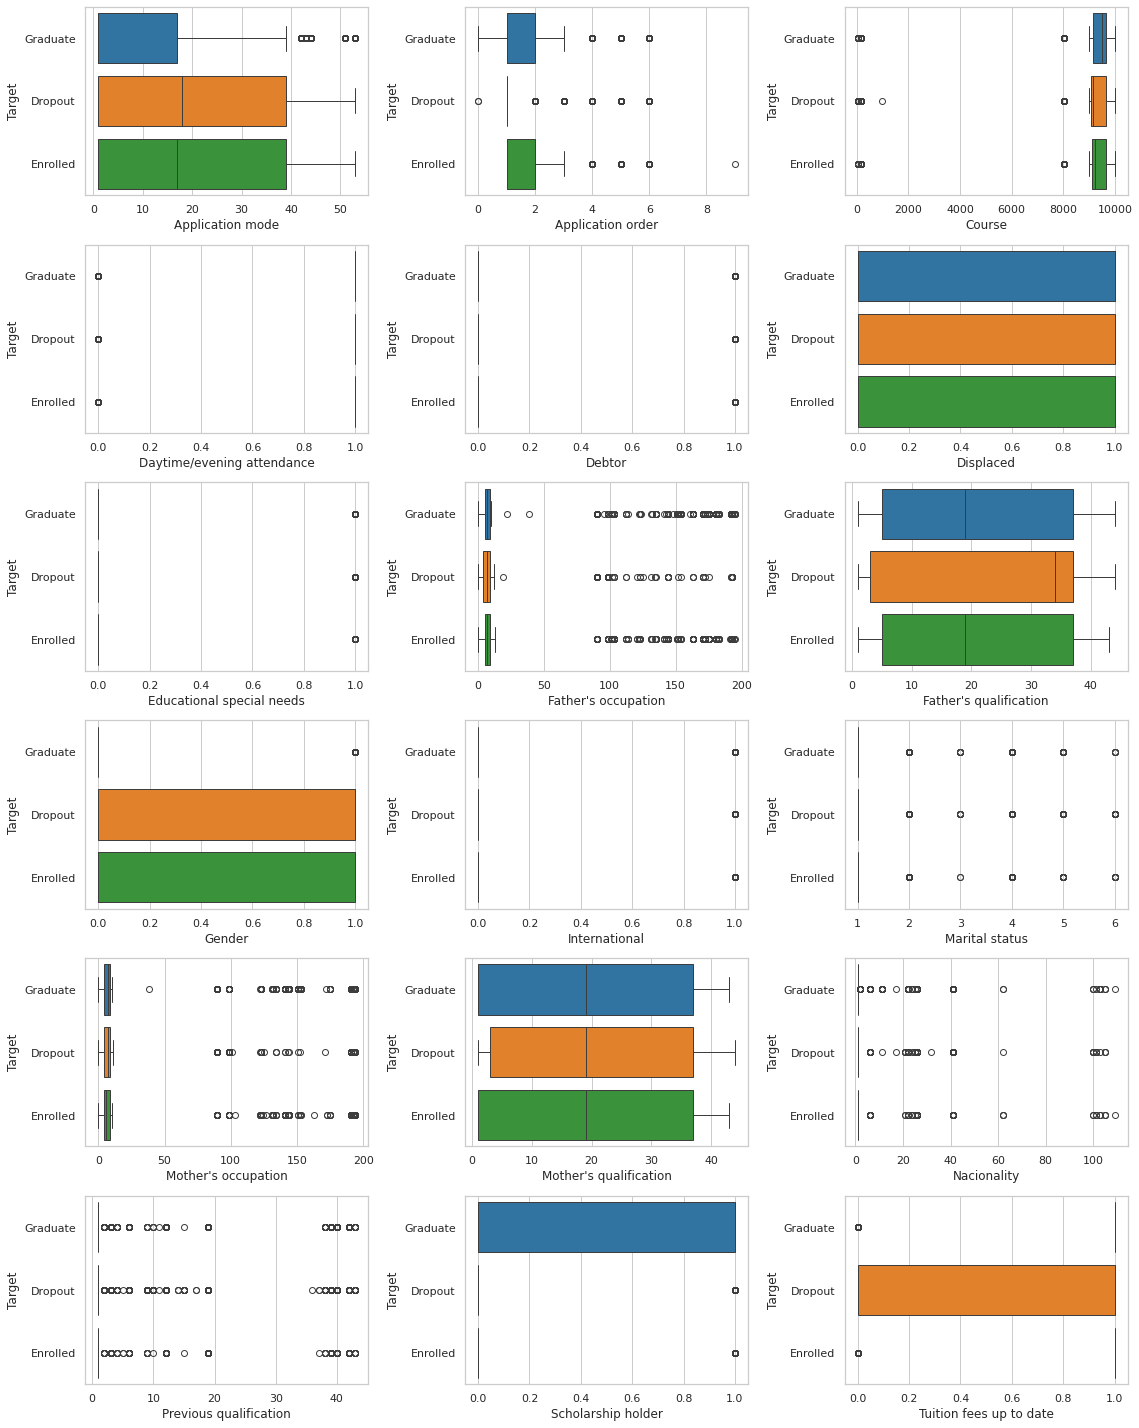

In [154]:
plt.figure(figsize=(16, 20))
for i, col in enumerate(categorical_features):
    plt.subplot(6, 3, i+1)
    sns.boxplot(data=train, x=col, y=target, palette=custom_palette)
plt.tight_layout()
plt.show()

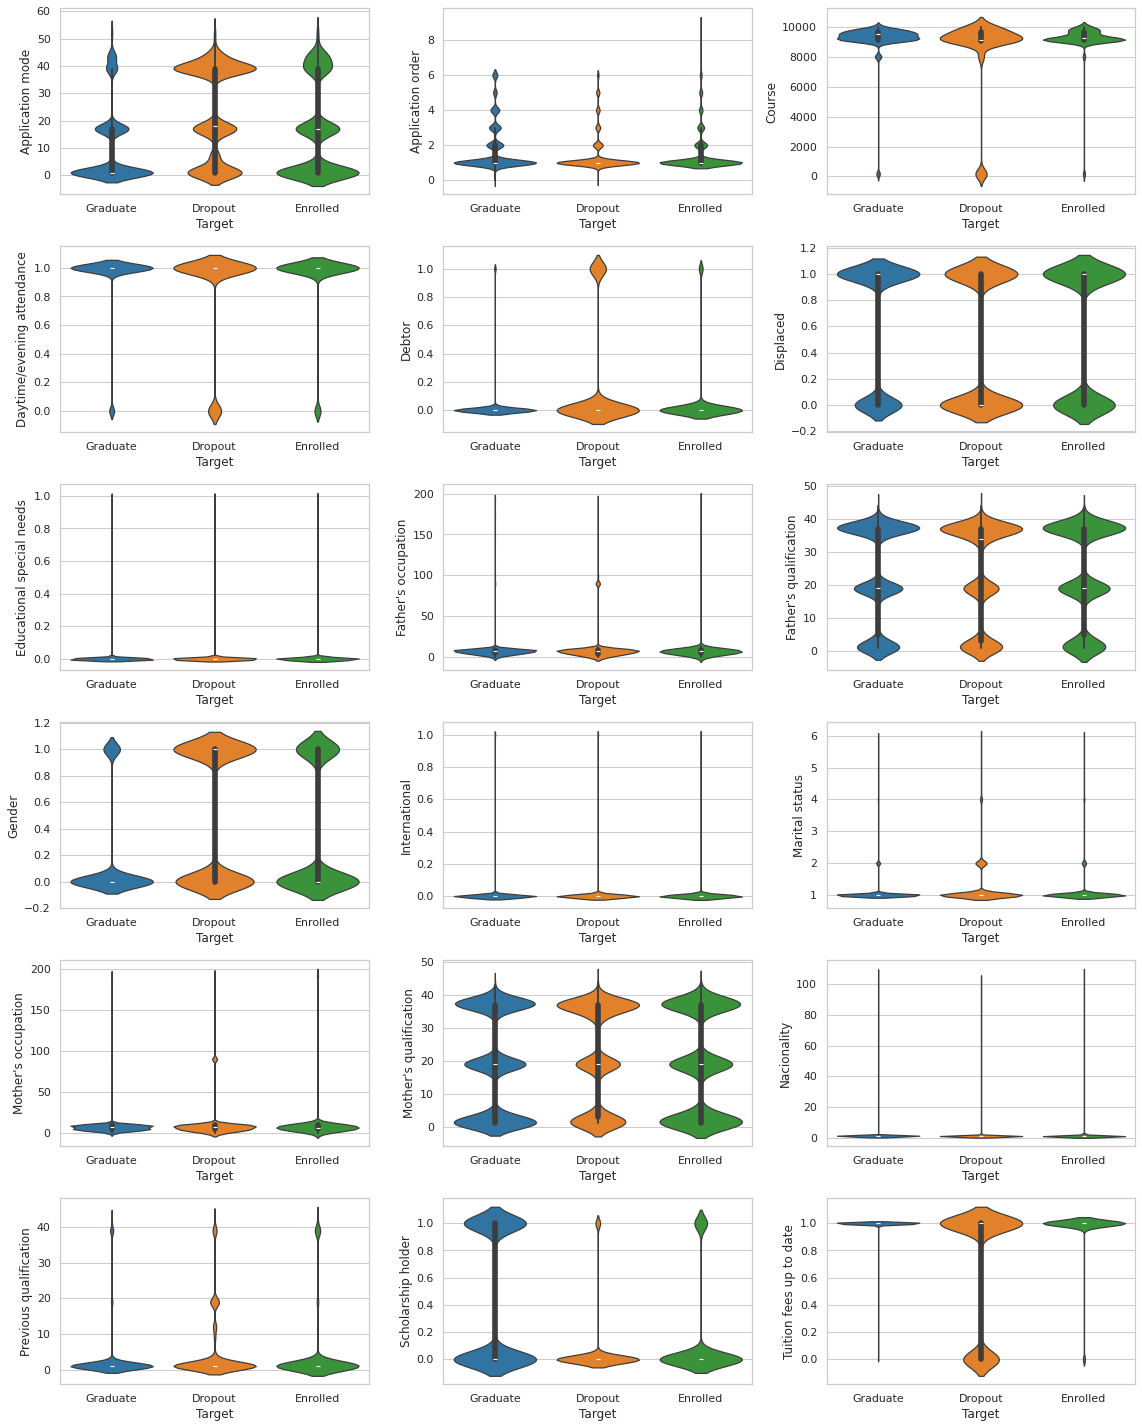

In [155]:
plt.figure(figsize=(16, 20))
for i, col in enumerate(categorical_features):
    plt.subplot(6, 3, i+1)
    sns.violinplot(data=train, x=target, y=col, palette=custom_palette)
plt.tight_layout()
plt.show()

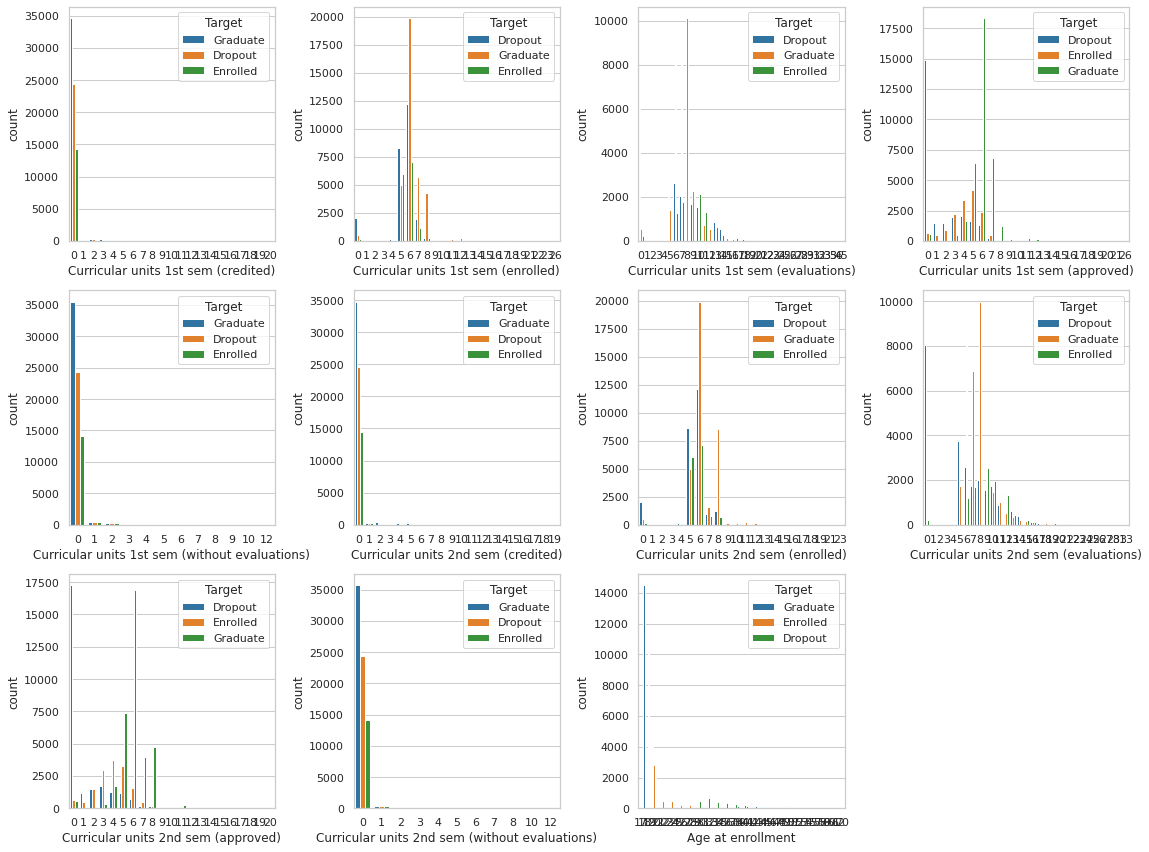

In [156]:
plt.figure(figsize=(16, 12))
for i, col in enumerate(discrete_features):
    plt.subplot(3, 4, i+1)
    sns.countplot(data=train, x=col, hue=target, palette=custom_palette)
plt.tight_layout()
plt.show()

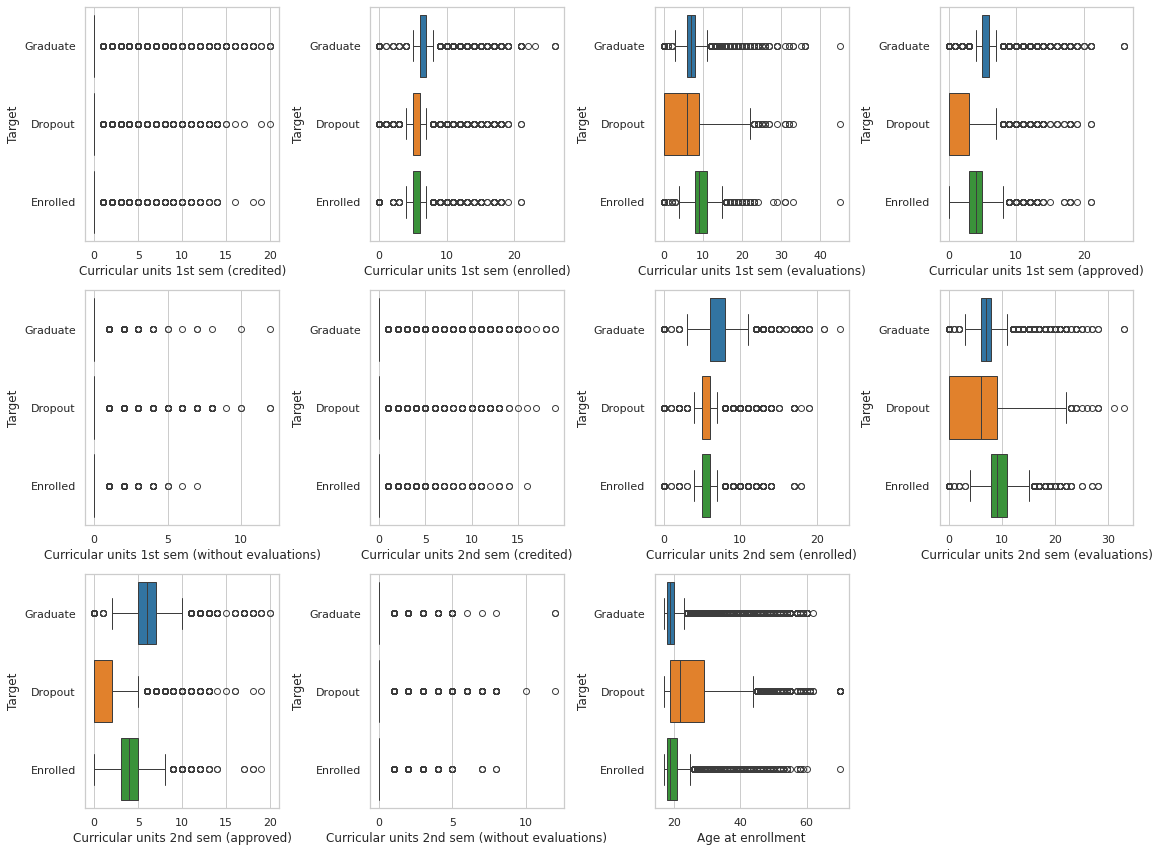

In [157]:
plt.figure(figsize=(16, 12))
for i, col in enumerate(discrete_features):
    plt.subplot(3, 4, i+1)
    sns.boxplot(data=train, x=col, y=target, palette=custom_palette)
plt.tight_layout()
plt.show()

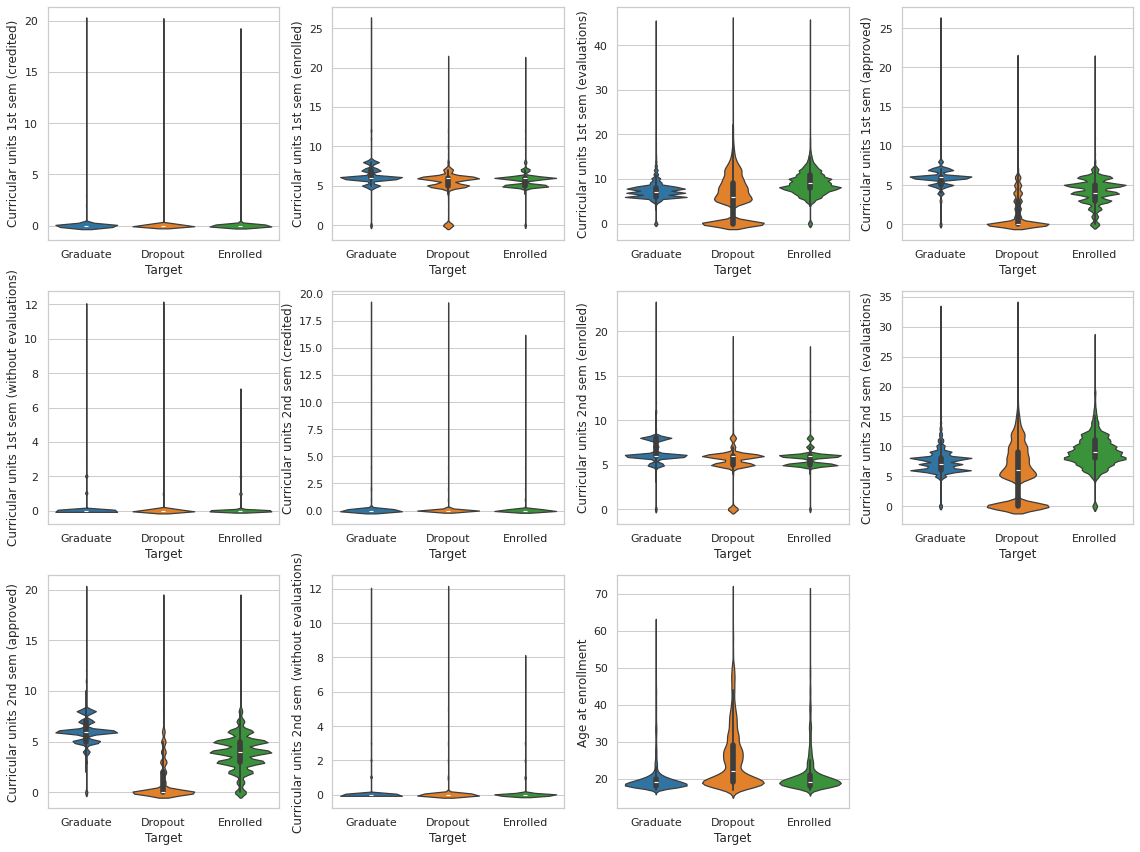

In [159]:
plt.figure(figsize=(16, 12))
for i, col in enumerate(discrete_features):
    plt.subplot(3, 4, i+1)
    sns.violinplot(data=train, x=target, y=col, palette=custom_palette)
plt.tight_layout()
plt.show()

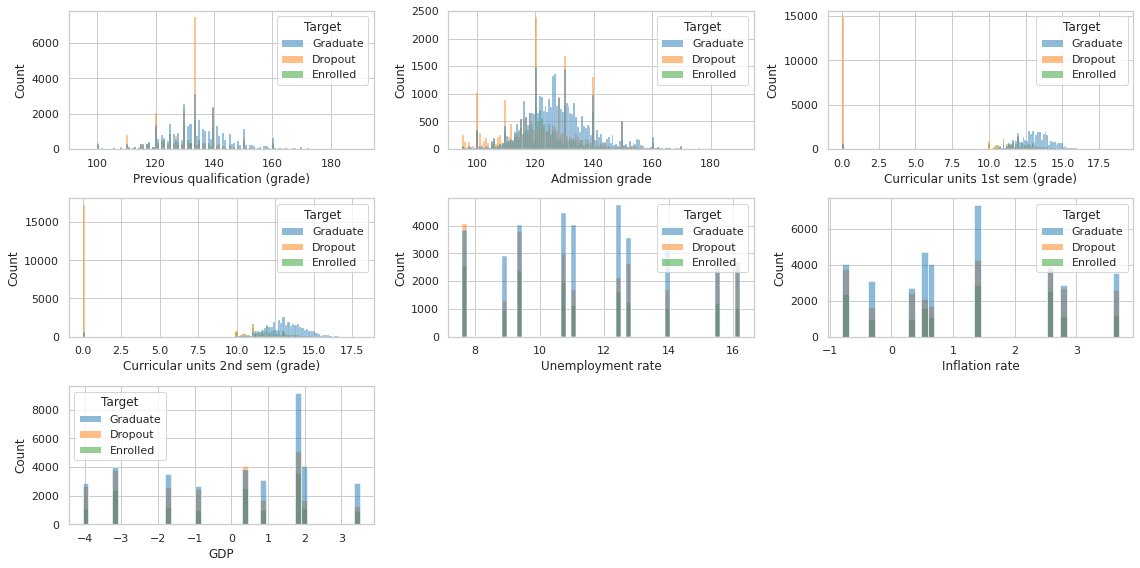

In [161]:
plt.figure(figsize=(16, 8))
for i, col in enumerate(continuous_features):
    plt.subplot(3, 3, i+1)
    sns.histplot(data=train, x=col, hue=target, palette=custom_palette)
plt.tight_layout()
plt.show()

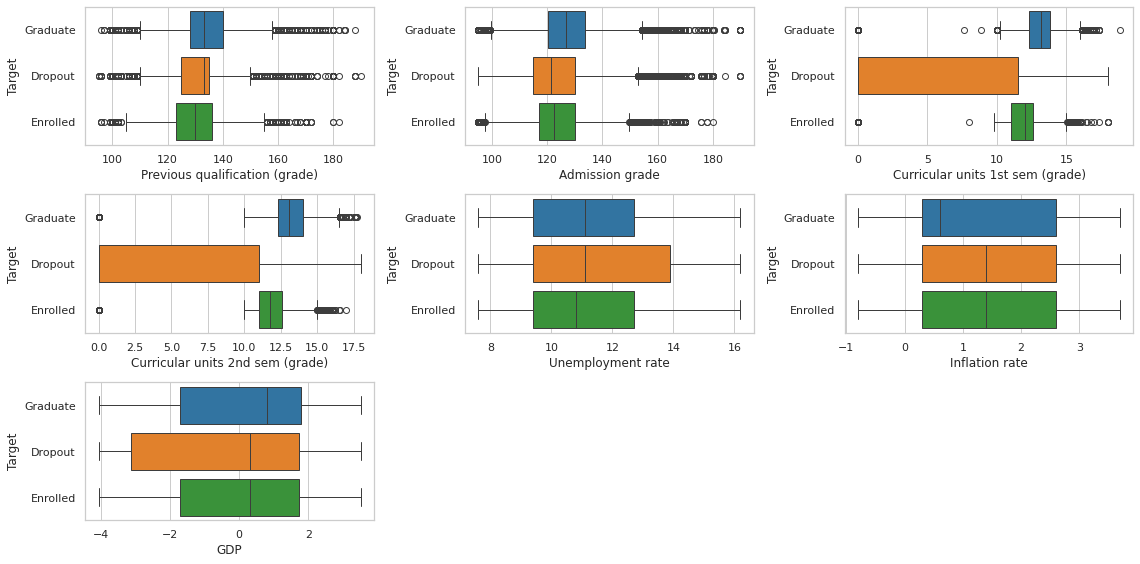

In [162]:
plt.figure(figsize=(16, 8))
for i, col in enumerate(continuous_features):
    plt.subplot(3, 3, i+1)
    sns.boxplot(data=train, x=col, y=target, palette=custom_palette)
plt.tight_layout()
plt.show()

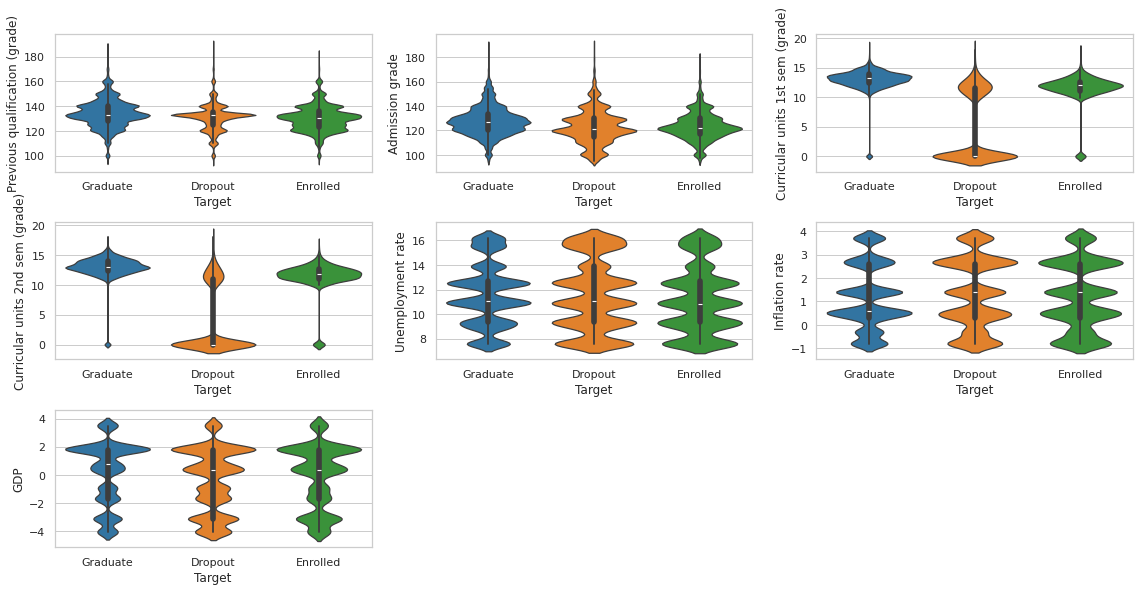

In [163]:
plt.figure(figsize=(16, 8))
for i, col in enumerate(continuous_features):
    plt.subplot(3, 3, i+1)
    sns.violinplot(data=train, x=target, y=col, palette=custom_palette)
plt.tight_layout()
plt.show()

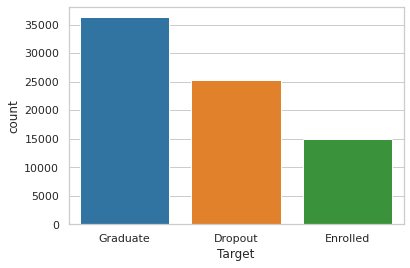

In [164]:
sns.countplot(data=train, x=target, palette=custom_palette)
plt.show()

In [165]:
lab_enc = LabelEncoder()
train[target] = lab_enc.fit_transform(train[target])

In [168]:
sp_cols = [
    "Application mode",
    "Course",
    "Previous qualification",
    "Nacionality",
    "Mother's qualification",
    "Father's qualification",
    "Mother's occupation",
    "Father's occupation"
]


def nunique(x):
    return len(np.unique(x))


unique_count = {}
unique_count["columns"] = sp_cols
unique_count["in_training"] = [nunique(train[col]) for col in sp_cols]
unique_count["training + test"] = [nunique(np.concatenate([train[col], test[col]])) for col in sp_cols]

unique_count = pd.DataFrame(unique_count)
unique_count.to_csv('unique_count.csv')
unique_count


,columns,in_training,training + test
0,Application mode,22,24
1,Course,19,23
2,Previous qualification,21,22
3,Nacionality,18,19
4,Mother's qualification,35,37
5,Father's qualification,39,41
6,Mother's occupation,40,45
7,Father's occupation,56,58


In [169]:
lab_encoder = LabelEncoder()
for col in sp_cols:
    lab_encoder.fit(np.unique(np.concatenate([train[col], test[col]])))
    train[col] = lab_encoder.transform(train[col])
    test[col] = lab_encoder.transform(test[col])

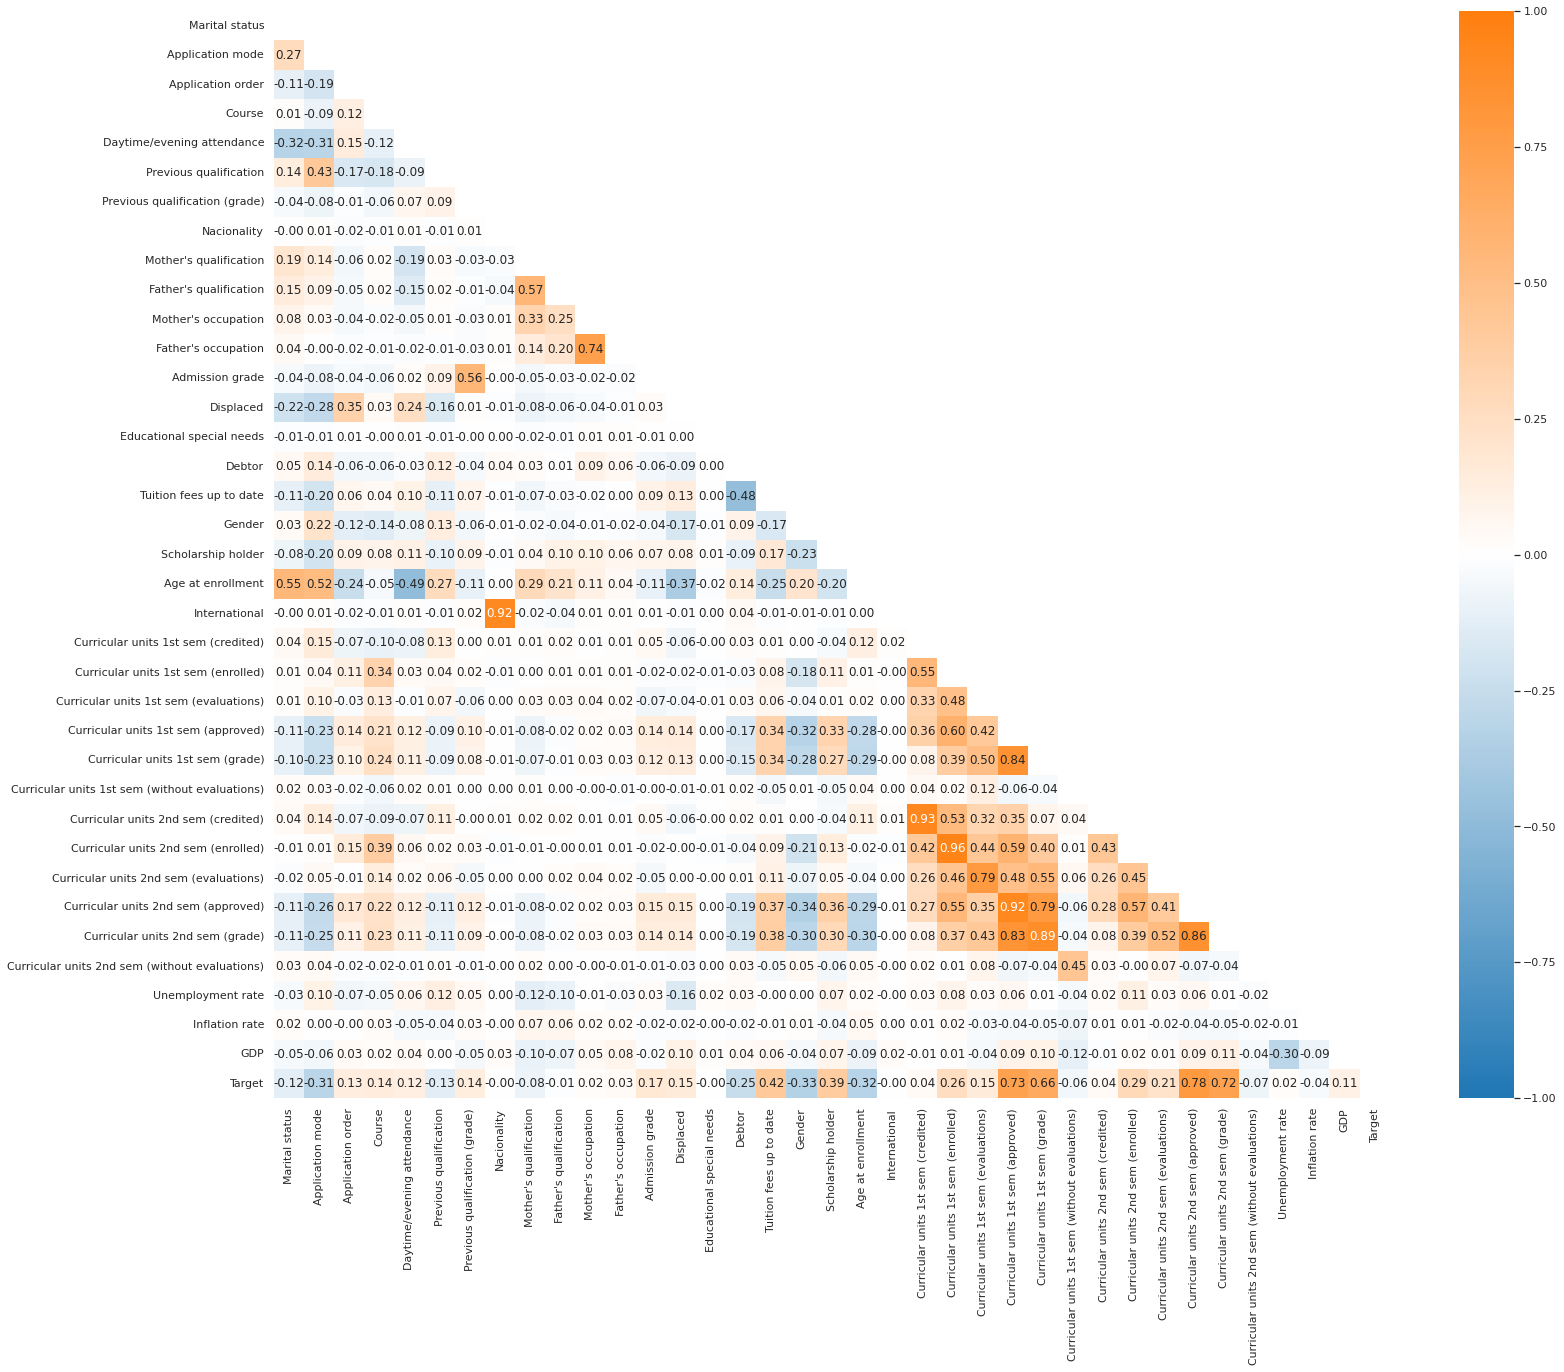

In [176]:
from matplotlib.colors import LinearSegmentedColormap
cor_mat = train.corr(method="pearson")

mask = np.triu(np.ones_like(cor_mat))


# 设置自定义颜色风格
custom_palette = ['#1f77b4', '#ffffff', '#ff7f0e']  # 蓝色、白色、橙色
cmap = LinearSegmentedColormap.from_list("custom_cmap", custom_palette, N=256)

# 绘制热图
plt.figure(figsize=(25, 20))
sns.heatmap(cor_mat, annot=True, fmt=".2f", cmap = cmap, mask=mask, center=0, vmin=-1, vmax=1)
plt.show()

In [177]:
X = train.drop(target, axis=1)
y = train[target]

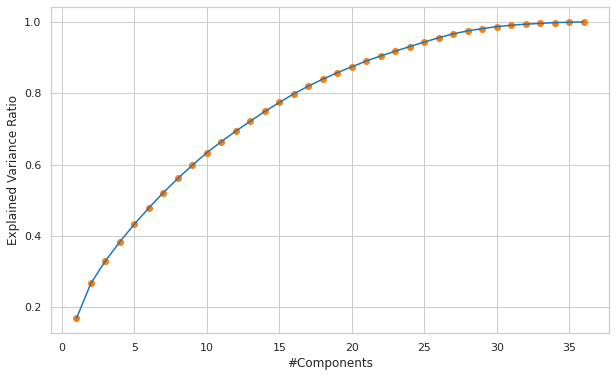

In [179]:
pca = PCA()

# 设置自定义颜色风格
# custom_palette = ['#1f77b4', '#ffffff', '#ff7f0e']  # 蓝色、白色、橙色
pca_pipe = make_pipeline(StandardScaler(), pca)

pca_pipe.fit(X)
explained_variance_ratio = np.cumsum(pca_pipe[-1].explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(X.columns)+1), explained_variance_ratio, '#1f77b4')
plt.scatter(range(1, len(X.columns)+1), explained_variance_ratio, c='#ff7f0e')
plt.xlabel("#Components")
plt.ylabel("Explained Variance Ratio")
plt.show()

In [191]:
def plot(x, **kwargs):
    plt.scatter(x[:, 0], x[:, 1], c=y, s=3, **kwargs)

In [195]:
colors = ['#1f77b4', '#ff7f0e']

# 自定义 plot 函数
def plot(x, **kwargs):
    plt.scatter(x[:, 0], x[:, 1], c=[colors[i] for i in y], s=3, **kwargs)

In [181]:
%%time

embedding_standard = openTSNE.TSNE(
    perplexity=30,
    initialization="random",
    metric="euclidean",
    n_jobs=8,
    random_state=42,
).fit(np.array(X))

CPU times: user 4min 41s, sys: 8.81 s, total: 4min 50s
Wall time: 2min 7s


In [182]:
%%time
embedding_pca = openTSNE.TSNE(
    perplexity=30,
    initialization="pca",
    metric="euclidean",
    n_jobs=8,
    random_state=42,
).fit(np.array(X))

CPU times: user 4min 48s, sys: 12.5 s, total: 5min 1s
Wall time: 2min 10s


In [183]:
%%time
embedding_cosine = openTSNE.TSNE(
    perplexity=30,
    initialization="random",
    metric="cosine",
    n_jobs=8,
    random_state=3,
).fit(np.array(X))

CPU times: user 4min 49s, sys: 8.39 s, total: 4min 58s
Wall time: 2min 4s


In [184]:
%%time
embedding_pca_cosine = openTSNE.TSNE(
    perplexity=30,
    initialization="pca",
    metric="cosine",
    n_jobs=8,
    random_state=3,
).fit(np.array(X))

CPU times: user 4min 59s, sys: 13.3 s, total: 5min 12s
Wall time: 2min 11s


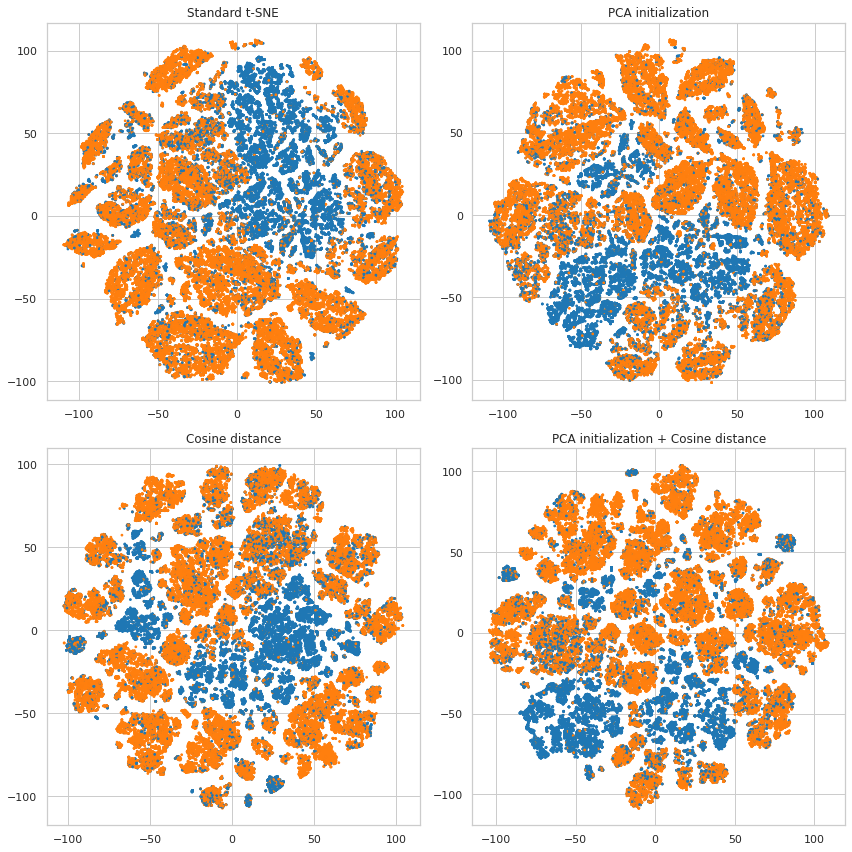

In [198]:
# 定义和谐的蓝色和橙色配色方案
colors = np.array(['#1f77b4' if i == 0 else '#ff7f0e' for i in y])

# 自定义 plot 函数
def plot(x, colors, **kwargs):
    plt.scatter(x[:, 0], x[:, 1], c=colors, s=3, **kwargs)

plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plot(embedding_standard, colors)
plt.title("Standard t-SNE")

plt.subplot(2, 2, 2)
plot(embedding_pca, colors)
plt.title("PCA initialization")

plt.subplot(2, 2, 3)
plot(embedding_cosine, colors)
plt.title("Cosine distance")

plt.subplot(2, 2, 4)
plot(embedding_pca_cosine, colors)
plt.title("PCA initialization + Cosine distance")

plt.tight_layout()
plt.show()

In [199]:
train_sample = train.sample(5000)

reducer = UMAP()

res = reducer.fit_transform(train_sample.drop(target, axis=1))

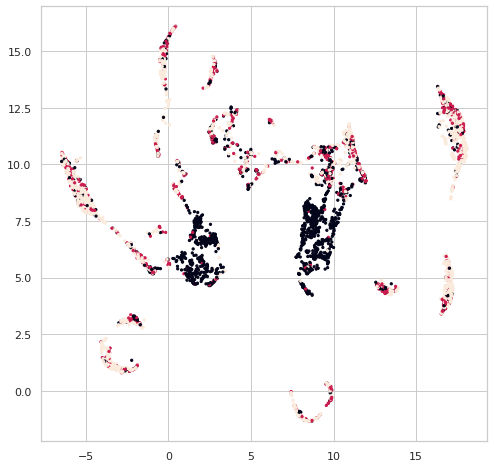

In [204]:
plt.figure(figsize=(8, 8))
plt.scatter(res[:, 0], res[:, 1], c=train_sample[target], s=5)
plt.show()

In [ ]:
discrete_features = X.dtypes == int


def mi_score_maker(X, y, discrete_features):
    scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    df = pd.DataFrame({
        'Features': X.columns,
        'Scores': scores
    })
    df = df.sort_values(['Scores'], ascending=False).reset_index(drop=True)
    return df

In [ ]:
mi_scores = mi_score_maker(X, y, discrete_features)

mi_scores

,Features,Scores
0,Curricular units 2nd sem (approved),0.478434
1,Curricular units 2nd sem (grade),0.414932
2,Curricular units 1st sem (approved),0.404898
3,Curricular units 1st sem (grade),0.365151
4,Curricular units 2nd sem (evaluations),0.195230
5,Curricular units 1st sem (evaluations),0.186579
6,Course,0.115707
7,Admission grade,0.104580
8,Tuition fees up to date,0.102676
9,Age at enrollment,0.096284


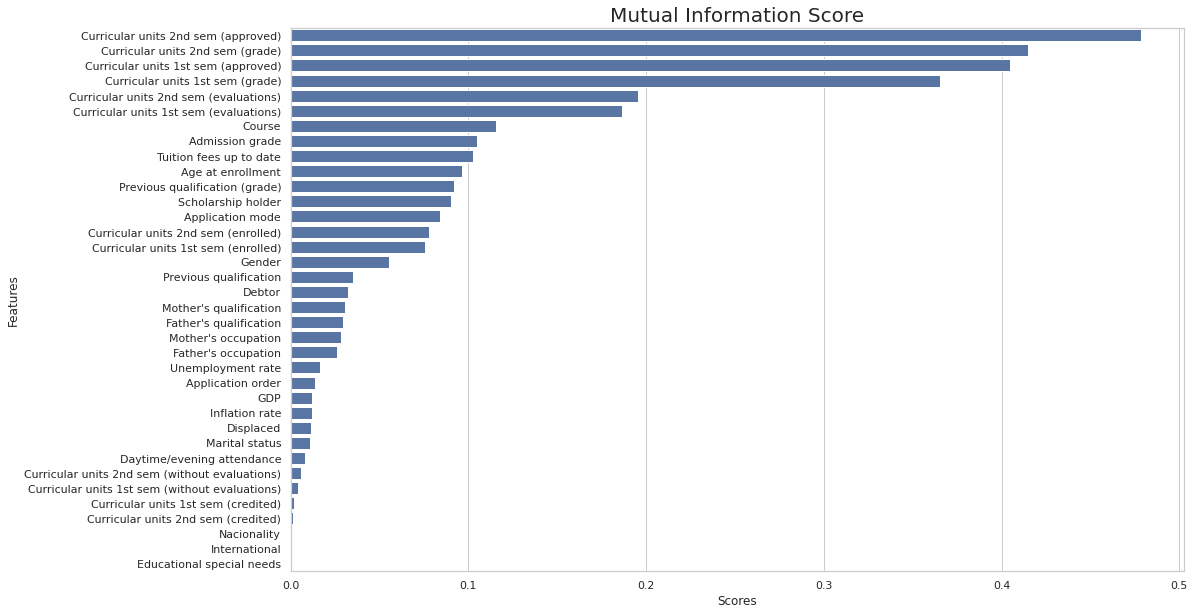

In [ ]:
plt.figure(figsize=(16, 10))
sns.barplot(x="Scores", y="Features", data=mi_scores)
plt.title("Mutual Information Score", size=20)
plt.show()

In [ ]:
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

def model_scorer(model, X, y):
    scores = cross_val_score(model, X, y, cv=skfold, scoring="accuracy")
    return scores.mean()

In [ ]:
%%time

cat_clf = CatBoostClassifier(allow_writing_files=False, verbose=False, task_type="GPU", random_state=42)
cat_pipe = make_pipeline(StandardScaler(), cat_clf)

model_scorer(cat_pipe, X, y)

CPU times: user 1min 29s, sys: 26 s, total: 1min 55s
Wall time: 37.9 s


0.8309155867478827

In [ ]:
%%time

xgb_clf = XGBClassifier(device="cuda", random_state=42)
xgb_pipe = make_pipeline(StandardScaler(), xgb_clf)

model_scorer(xgb_pipe, X, y)

CPU times: user 13.8 s, sys: 111 ms, total: 13.9 s
Wall time: 6.99 s


0.8312945726339255

In [ ]:
%%time

lgb_clf = LGBMClassifier(verbose=-1, device="cpu", random_state=42)
lgb_pipe = make_pipeline(StandardScaler(), lgb_clf)

model_scorer(lgb_pipe, X, y)

CPU times: user 2min 5s, sys: 762 ms, total: 2min 6s
Wall time: 12.2 s


0.8311900743374567

In [ ]:
%%time

hgb_clf = HistGradientBoostingClassifier(random_state=42)
hgb_pipe = make_pipeline(StandardScaler(), hgb_clf)

model_scorer(hgb_pipe, X, y)

CPU times: user 3min 34s, sys: 717 ms, total: 3min 34s
Wall time: 19.7 s


0.8312815417327378

In [ ]:
models = [
    ("cat", cat_clf),
    ("xgb", xgb_clf),
    ("lgb", lgb_clf),
    ("hgb", hgb_clf)
]

vtg_clf = VotingClassifier(estimators=models, voting="soft", n_jobs=-1)
vtg_pipe = make_pipeline(StandardScaler(), vtg_clf)

In [ ]:
from lightgbm import LGBMClassifier


model_scorer(vtg_pipe, X, y)

0.8328628447518007

In [ ]:
x_train, x_test = train_test_split(train, test_size=0.1, shuffle=True, random_state=42, stratify=train.Target)
y_train = x_train.pop(target)
y_test = x_test.pop(target)

vtg_pipe.fit(x_train, y_train)
y_pred = vtg_pipe.predict(x_test)

print(classification_report(lab_enc.inverse_transform(y_test),
                            lab_enc.inverse_transform(y_pred)))


              precision    recall  f1-score   support

     Dropout       0.90      0.83      0.86      2530
    Enrolled       0.65      0.61      0.63      1494
    Graduate       0.85      0.92      0.88      3628

    accuracy                           0.83      7652
   macro avg       0.80      0.79      0.79      7652
weighted avg       0.83      0.83      0.83      7652



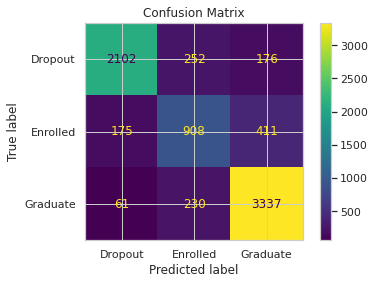

In [ ]:
confusion_mat = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_mat, display_labels=lab_enc.classes_.tolist()).plot()
plt.title("Confusion Matrix")
plt.show()

In [ ]:
vtg_pipe.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('votingclassifier',
                 VotingClassifier(estimators=[('cat',
                                               <catboost.core.CatBoostClassifier object at 0x7f11080ead90>),
                                              ('xgb',
                                               XGBClassifier(base_score=None,
                                                             booster=None,
                                                             callbacks=None,
                                                             colsample_bylevel=None,
                                                             colsample_bynode=None,
                                                             colsample_bytree=None,
                                                             device='cuda',
                                                             early_stopping_rounds=None,
                                                             enable_cate...
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=None,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=42, ...)),
                                              ('lgb',
                                               LGBMClassifier(device='cpu',
                                                              random_state=42,
                                                              verbose=-1)),
                                              ('hgb',
                                               HistGradientBoostingClassifier(random_state=42))],
                                  n_jobs=-1, voting='soft'))])

In [ ]:
test_pred = vtg_pipe.predict(test)

In [ ]:
sub = pd.read_csv("/root/autodl-tmp/XJTU-ELEC427304-homework/kaggle_graduate_prediect/sample_submission.csv")
sub[target] = lab_enc.inverse_transform(test_pred)
sub

,id,Target
0,76518,Dropout
1,76519,Graduate
2,76520,Graduate
3,76521,Enrolled
4,76522,Enrolled
...,...,...
51007,127525,Dropout
51008,127526,Dropout
51009,127527,Dropout
51010,127528,Dropout


In [ ]:
sub.to_csv("submission.csv", index=False)